# 🎯 Objetivos

Este proyecto se desarrolla en el marco de la asignatura Data Mining de la Maestría en Explotación de Datos y Descubrimiento del Conocimiento de la Facultad de Ciencias Exactas y Naturales de la Universidad de Buenos Aires (UBA). Su objetivo principal es construir un modelo predictivo que permita estimar el precio de propiedades inmobiliarias en la Ciudad Autónoma de Buenos Aires (CABA), Argentina.

Utilizando un conjunto de datos proveniente del portal [Properati](https://www.properati.com.ar/), se busca identificar y modelar los factores que inciden de forma significativa en el valor de las propiedades (como la ubicación geográfica, el tipo de inmueble, la superficie y la presencia de determinadas comodidades o servicios) con el fin de predecir el valor de publicaciones futuras en el mercado.

Este trabajo integra técnicas de preprocesamiento de datos, análisis exploratorio, ingeniería de atributos y algoritmos de aprendizaje automático supervisado. El modelo resultante aspira a ser una herramienta útil para diversos actores del mercado inmobiliario, como compradores, vendedores y profesionales del rubro, al ofrecer estimaciones objetivas y basadas en datos en un contexto urbano dinámico y complejo.



# 🥈 Contexto y evaluación

La evaluación del proyecto se realizó mediante una competencia interna en la plataforma Kaggle, donde los participantes debían desarrollar modelos predictivos y optimizar su desempeño frente a un conjunto de datos oculto. En dicha competencia, el modelo presentado obtuvo el segundo puesto entre los 75 participantes, destacándose por su capacidad de generalización y precisión.

# 📦 Importación de librerías y dirección de los archivos

In [1]:
DIR = "/content/drive/MyDrive/Github/prediccion-precio-de-propiedades/data"
# DIR = r"C:\Users\Facundo San Martino\Desktop\data_mining"

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn as sk
from sklearn import model_selection
from sklearn import ensemble
from sklearn import metrics
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
import re

In [3]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


# 🧩 Funciones

In [4]:
def palabra_clave_a_columna(df, palabras_clave, nombre_de_columna, col_title='title', col_description='description'):
    '''
    Modifica el dataframe agregando una columna booleana (1 o 0) indicando si
    en el título o la descripción aparece alguna palabra clave, como palabra completa.
    '''

    # Genera un patrón regex con límites de palabra (\b) para evitar coincidencias parciales
    patrones = [rf"\b{re.escape(pal)}\b" for pal in palabras_clave]
    regex_pattern = '|'.join(patrones)
    regex_compilado = re.compile(regex_pattern, flags=re.IGNORECASE)

    def contiene_palabra_clave(texto):
        if pd.isnull(texto):
            return False
        return bool(regex_compilado.search(texto))

    df[nombre_de_columna] = df[[col_title, col_description]].apply(
        lambda row: int(
            contiene_palabra_clave(str(row[col_title])) or contiene_palabra_clave(str(row[col_description]))
        ),
        axis=1
    )

In [5]:
def ajustar_superficie_cocheras(df, col_texto_1='title', col_texto_2='description', col_superficie='surface_covered'):
    """
    Ajusta surface_covered basado en la PRIMERA aparición de palabras clave, con prioridad en el título.

    Lógica:
    1. Busca en col_texto_1 (title) la PRIMERA coincidencia de:
       - "descubierta" → 0
       - "cubierta" → mantiene valor
    2. Si no hay match en col_texto_1, busca en col_texto_2 (description) la PRIMERA coincidencia

    Parámetros:
        df: DataFrame
        col_texto_1: Columna con texto principal (default: 'title')
        col_texto_2: Columna con texto secundario (default: 'description')
        col_superficie: Columna a modificar (default: 'surface_covered')

    Retorna:
        DataFrame modificado
    """
    df = df.copy()

    # Función para encontrar primera coincidencia
    def primera_coincidencia(serie):
        resultados = []
        for texto in serie:
            if pd.isna(texto):
                resultados.append(None)
                continue

            texto_lower = str(texto).lower()
            descubierta_pos = texto_lower.find('descubierta')
            cubierta_pos = texto_lower.find('cubierta')

            # Determinar primera coincidencia válida
            if descubierta_pos != -1 and cubierta_pos != -1:
                resultado = 'descubierta' if descubierta_pos < cubierta_pos else 'cubierta'
            elif descubierta_pos != -1:
                resultado = 'descubierta'
            elif cubierta_pos != -1:
                resultado = 'cubierta'
            else:
                resultado = None

            resultados.append(resultado)
        return pd.Series(resultados, index=serie.index)

    # Procesar título
    titulo_match = primera_coincidencia(df[col_texto_1])
    df.loc[titulo_match == 'descubierta', col_superficie] = 0

    # Procesar descripción solo para registros no decididos
    pendientes = titulo_match.isna()
    # Convertir la Serie booleana a un array numpy para indexación
    mask_pendientes = pendientes.values
    descripcion_match = primera_coincidencia(df.loc[mask_pendientes, col_texto_2])
    df.loc[descripcion_match[descripcion_match == 'descubierta'].index, col_superficie] = 0

    return df

In [6]:
def extraer_superficie_de_texto(df, col_texto_1='title', col_texto_2='description', col_superficie='surface_total'):
    """
    Extrae el valor de superficie cuando aparece antes de "m2" en el texto y asigna a surface_total si es NaN.

    Lógica:
    1. Busca en col_texto_1 (title) el patrón numérico antes de "m2"
    2. Si no encuentra en título, busca en col_texto_2 (description)
    3. Solo asigna si surface_total es NaN

    Parámetros:
        df: DataFrame
        col_texto_1: Columna con texto principal (default: 'title')
        col_texto_2: Columna con texto secundario (default: 'description')
        col_superficie: Columna a modificar (default: 'surface_total')

    Retorna:
        DataFrame modificado
    """
    df = df.copy()

    # Patrón regex para encontrar números antes de m2 (ej: "100 m2" o "100m2")
    patron = re.compile(r'(\d+)\s*m2', re.IGNORECASE)

    # Función para extraer el primer valor encontrado
    def extraer_valor(texto):
        if pd.isna(texto):
            return np.nan  # Usamos np.nan en lugar de None para mantener consistencia de tipos
        match = patron.search(str(texto))
        return float(match.group(1)) if match else np.nan

    # Primero procesar el título
    df['temp_surface'] = df[col_texto_1].apply(extraer_valor).astype('float64')

    # Para registros donde no se encontró en título y surface_total es NaN, buscar en descripción
    mask = df['temp_surface'].isna() & df[col_superficie].isna()
    df.loc[mask, 'temp_surface'] = df.loc[mask, col_texto_2].apply(extraer_valor).astype('float64')

    # Asignar los valores encontrados a surface_total (solo si es NaN)
    mask_asignar = df[col_superficie].isna() & df['temp_surface'].notna()
    df.loc[mask_asignar, col_superficie] = df.loc[mask_asignar, 'temp_surface']

    # Eliminar columna temporal
    df.drop(columns=['temp_surface'], inplace=True)

    return df

In [7]:
def calcular_superficie_cochera(df, col_texto='description', col_superficie='surface_total'):
    """
    Versión optimizada que:
    1. Busca patrones "A X B" en el texto (ej: "5,00 X 2.50").
    2. Retorna np.nan si no hay match (en lugar de None).
    3. Asigna solo a registros donde surface_total es NaN.
    """
    df = df.copy()

    # Patrón regex mejorado (admite "5x3", "5.5 X 3,2", etc.)
    patron = re.compile(r'(\d+[,.]?\d*)\s*[xX×]\s*(\d+[,.]?\d*)')

    def extraer_superficie(texto):
        if pd.isna(texto):
            return np.nan  # Manejo directo de NaN

        match = patron.search(str(texto))
        if not match:
            return np.nan  # ¡Aquí está la clave! Retornamos np.nan

        try:
            num1 = float(match.group(1).replace(',', '.'))
            num2 = float(match.group(2).replace(',', '.'))
            return num1 * num2
        except (ValueError, AttributeError):
            return np.nan

    # Aplicar solo si surface_total es NaN
    mask = df[col_superficie].isna()
    df.loc[mask, col_superficie] = df.loc[mask, col_texto].apply(extraer_superficie)

    return df

In [8]:
def contar_valores(df, columnas):
  return df[columnas].value_counts(normalize=True)*100

In [9]:
def completar_l4_con_subbarrios_desde_texto(df):
    # Mapeo de sub-barrios extendidos a categorías principales
    # Si se encuentra la llave (ej. barrio norte) en el texto del título o la descrición, le asigna el valor a la columna l4.
    subbarrio_map = {
        'palermo soho': 'Palermo Soho',
        'palermo sojo': 'Palermo Soho',
        'soho': 'Palermo Soho',
        'palermo viejo': 'Palermo Viejo',
        'alto palermo': 'Barrio Norte',
        'palermo chico': 'Palermo Chico',
        'palermo hollywood': 'Palermo Hollywood',
        'hollywood': 'Palermo Hollywood',
        'barrio parque': 'Barrio Parque',
        'barrio norte': 'Barrio Norte',
        'recoleta norte': 'Barrio Norte',
        'las cañitas': 'Las Cañitas',
        'palermo botanico': 'Palermo Chico',
        'palermo zoologico': 'Palermo Chico',
        'palermo alto': 'Palermo Chico',
        'palermo queens': 'Palermo Soho',
        'palermo green': 'Palermo Hollywood',
        'las caitas': 'Las Cañitas',
        'las canitas': 'Las Cañitas',
        'cañitas': 'Las Cañitas',
        'canitas': 'Las Cañitas',
        'belgrano bajo': 'Belgrano Chico',
        'bajo belgrano': 'Belgrano Chico',
        'belgrano chico': 'Belgrano Chico',
        'belgrano r': 'Belgrano R'

    }

    def buscar_subbarrio(row):
        '''Si encuentra alguna coincidencia en el texto (título o descripción), devuelve el subbarrio correspondiente
          y lo asigna a l4 aunque ya esté asignado.'''

        texto = f"{row.get('title', '')} {row.get('description', '')}".lower()
        for key in subbarrio_map:
            if key in texto:
                return subbarrio_map[key]
        return row['l4']  # Si no se encuentra ningún subbarrio, se mantiene el valor actual

    # Sobrescribe l4 según el texto, si encuentra coincidencia
    df.loc[:, 'l4'] = df.apply(buscar_subbarrio, axis=1)

In [10]:
def entrenar_knn_subbarrio(df, barrio_objetivo, n_neighbors=5):
    # Se entrena un modelo KNN para predecir el valor de l4 basado en lat y lon (notna).
    df_entrenamiento = df[
        (df["l4"].notna()) & (df["lat"].notna()) & (df["lon"].notna())
    ]

    if df_entrenamiento.empty:
        print("No hay datos suficientes para entrenar el modelo.")
        return None

    X_train = df_entrenamiento[["lat", "lon"]]
    y_train = df_entrenamiento["l4"]

    knn = KNeighborsClassifier(n_neighbors=n_neighbors)
    knn.fit(X_train, y_train)
    return knn

In [11]:
def imputar_l4_con_knn(df, barrio_objetivo, knn):
    # Se usa el modelo KNN previamente entrenado para imputar los valores faltantes en l4 a partir de los datos de lat y lon no nulos.
    if knn is None:
        print("Modelo KNN no disponible.")
        return df

    cond_pred = (
        (df["l3"] == barrio_objetivo) &
        (df["l4"].isna()) &
        (df["lat"].notna()) &
        (df["lon"].notna())
    )

    if not cond_pred.any():
        print(f"No hay registros de {barrio_objetivo} con l4 nulo y coordenadas para imputar.")
        return df

    X_pred = df.loc[cond_pred, ["lat", "lon"]]
    y_pred = knn.predict(X_pred)

    df.loc[cond_pred, "l4"] = y_pred
    return df

In [12]:
def imputar_l4_knn_propiedades(df):
    # Se entrena un nuevo modelo KNN para imputar los valores de l4 faltantes a partir de las variables "features"
    features = ["rooms", "bedrooms", "bathrooms", "surface_total", "surface_covered"]

    df_train = df[df["l4"].notna()].dropna(subset=features)
    df_pred = df[df["l4"].isna()].dropna(subset=features)

    if df_train.empty or df_pred.empty:
        print("No hay suficientes datos.")
        return df

    X_train = df_train[features]
    y_train = df_train["l4"]
    X_pred = df_pred[features]

    # Escalamos las variables
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_pred_scaled = scaler.transform(X_pred)

    # Entrenamos KNN
    knn = KNeighborsClassifier(n_neighbors=5)
    knn.fit(X_train_scaled, y_train)

    # Predecimos
    y_pred = knn.predict(X_pred_scaled)

    # Imputamos
    df.loc[X_pred.index, "l4"] = y_pred

In [13]:
def porcentaje_nulos(df):

  # Calcula el % de valores nulos para cada atributo del df.

  porcentaje_nulos = round((df.isnull().sum() / df.shape[0] * 100).rename("% valores nulos").sort_values(ascending=False), 2)
  return porcentaje_nulos

In [14]:
def elimino_columnas(df, columnas):
    df.drop(columns=columnas, inplace=True)

In [15]:
def imputar_desde_texto(df, columna_objetivo, columnas_texto=["description", "title"], patrones=None):
    """
    Imputa valores en 'columna_objetivo' buscando patrones en múltiples columnas de texto.

    Parámetros:
    - df: DataFrame
    - columna_objetivo: str, columna que se quiere imputar (ej. 'bathrooms', 'rooms', 'bedrooms')
    - columnas_texto: lista de columnas de texto donde buscar patrones
    - patrones: dict, mapeo de valor numérico -> lista de expresiones asociadas
    """
    for valor, expresiones in patrones.items():
        for expr in expresiones:
            mask_base = df[columna_objetivo].isna()
            mask_text = False  # empezamos con False y vamos haciendo OR con cada columna
            for col in columnas_texto:
                mask_text |= df[col].str.lower().str.contains(expr, na=False)
            mask_final = mask_base & mask_text
            df.loc[mask_final, columna_objetivo] = valor

In [16]:
def completar_monoambientes(df):
    mask_monoambiente = df["title"].str.lower().str.contains("monoambiente", na=False)
    df.loc[mask_monoambiente & df["bathrooms"].isna(), "bathrooms"] = 1
    df.loc[mask_monoambiente & df["bedrooms"].isna(), "bedrooms"] = 0
    df.loc[mask_monoambiente & df["rooms"].isna(), "rooms"] = 1

In [17]:
def imputar_por_superficie(df):
    # Se completan los valores de rooms, bedrooms y bathrooms de acurdo a valores típico de surface_total.
    df = df.copy()

    # Crear máscara para excluir cocheras en cada imputación (pero no eliminarlas)
    mask_no_cochera = df["property_type"] != "Cochera"

    # Monoambiente (<= 40 m²)
    mask_1 = (df["surface_total"] <= 40) & mask_no_cochera
    df.loc[mask_1 & df["rooms"].isna(), "rooms"] = 1
    df.loc[mask_1 & df["bedrooms"].isna(), "bedrooms"] = 0
    df.loc[mask_1 & df["bathrooms"].isna(), "bathrooms"] = 1

    # 2 ambientes (40 < x < 60 m²)
    mask_2 = (df["surface_total"] > 40) & (df["surface_total"] < 60) & mask_no_cochera
    df.loc[mask_2 & df["rooms"].isna(), "rooms"] = 2
    df.loc[mask_2 & df["bedrooms"].isna(), "bedrooms"] = 1
    df.loc[mask_2 & df["bathrooms"].isna(), "bathrooms"] = 1

    # 3 ambientes (60 ≤ x < 80 m²)
    mask_3 = (df["surface_total"] >= 60) & (df["surface_total"] < 80) & mask_no_cochera
    df.loc[mask_3 & df["rooms"].isna(), "rooms"] = 3
    df.loc[mask_3 & df["bedrooms"].isna(), "bedrooms"] = 2
    df.loc[mask_3 & df["bathrooms"].isna(), "bathrooms"] = 1

    # 4 ambientes (80 ≤ x < 100 m²)
    mask_4 = (df["surface_total"] >= 80) & (df["surface_total"] < 100) & mask_no_cochera
    df.loc[mask_4 & df["rooms"].isna(), "rooms"] = 4
    df.loc[mask_4 & df["bedrooms"].isna(), "bedrooms"] = 3
    df.loc[mask_4 & df["bathrooms"].isna(), "bathrooms"] = 2

    # +100 m² (5 o más ambientes)
    mask_5 = (df["surface_total"] >= 100) & mask_no_cochera
    df.loc[mask_5 & df["rooms"].isna(), "rooms"] = 5
    df.loc[mask_5 & df["bedrooms"].isna(), "bedrooms"] = 4
    df.loc[mask_5 & df["bathrooms"].isna(), "bathrooms"] = 2

    return df

# 📂 Lectura de datos (entrenamiento y a predecir)

In [18]:
df_entrenamiento = pd.read_csv(f"{DIR}/entrenamiento.csv", index_col="id")

In [19]:
df_apredecir = pd.read_csv(f"{DIR}/a_predecir.csv", index_col="id")

In [20]:
df_ent = df_entrenamiento.copy()
df_ap = df_apredecir.copy()

# 🛠️ Filtros, transformaciones e imputaciones de los datos

In [21]:
# Convierto a formato fechas en los datos de entrenamiento como de a predecir: "start_date", "end_date", "created_on"

df_ap[["start_date", "end_date", "created_on"]] = df_ap[["start_date", "end_date", "created_on"]].apply(pd.to_datetime, format="%Y-%m-%d", errors='coerce')
df_ent[["start_date", "end_date", "created_on"]] = df_ent[["start_date", "end_date", "created_on"]].apply(pd.to_datetime, format="%Y-%m-%d", errors='coerce')

In [22]:
# Estan cambiadas las latitudes y longitudes.

df_ent.rename(columns={"lat":"lon", "lon":"lat"}, inplace=True)
df_ap.rename(columns={"lat":"lon", "lon":"lat"}, inplace=True)

In [23]:
columnas_categoricas = df_ap.select_dtypes('object').columns.difference(["title", "description"])

In [24]:
df_ent = df_ent.dropna(subset=["price"])

In [25]:
df_ap["property_type"].value_counts()

,count
property_type,
Departamento,6596
Casa,327
Cochera,89


In [26]:
# Creacion de filtro para set de entrenamiento en base a las distribuciones de las variables categoricas del set "a predecir". Se agrega PH para obtener más registros

filtro_l2 = df_ent["l2"] == "Capital Federal"
filtro_currency = df_ent["currency"] == "USD"
filtro_property_type = df_ent["property_type"].isin(["Casa", "Departamento", "Cochera", "PH"])
filtro_operation_type = df_ent["operation_type"] == "Venta"

df_ent = df_ent.loc[filtro_l2 & filtro_currency & filtro_property_type & filtro_operation_type]

In [27]:
# Agrego a los PHs como Casa
condicion = df_ent["property_type"] == "PH"
df_ent.loc[condicion, "property_type"] = "Casa"

In [28]:
# Me quedo con aquellos registos donde lat y lon sean de Capital Federal

df_ent = df_ent[(df_ent['lat'] < -34) & (df_ent['lat'] > -35)]
df_ent = df_ent[(df_ent['lon'] > -58.6) & (df_ent['lon'] < -58.3)]

In [29]:
# Creo una variable nueva variable para posteriormente ordenar el dataset por la fecha en orden descendiente y quedarme con el último aviso publicado si es que está duplicado.

df_ent.loc[:, 'fecha_orden'] = df_ent['start_date'].fillna(df_ent['created_on'])

In [30]:
df_ent = df_ent.sort_values('fecha_orden', ascending=False)

In [31]:
# En el subset no se incluye el precio. Me quiero quedar con el último registro por fecha.

duplicados = df_ent[df_ent.duplicated(subset=['ad_type', 'lon', 'lat', 'l1',
       'l2', 'l3', 'l4', 'l5', 'l6', 'rooms', 'bedrooms', 'bathrooms',
       'surface_total', 'surface_covered', 'currency', 'price_period', 'title',
       'description', 'property_type', 'operation_type'], keep='first')]

In [32]:
# # Me quedo con cada uno de los últimos registros duplicados (de la última fecha publicada)

# df_ent = df_ent.drop_duplicates(subset=['ad_type', 'lon', 'lat', 'l1',
#        'l2', 'l3', 'l4', 'l5', 'l6', 'rooms', 'bedrooms', 'bathrooms',
#        'surface_total', 'surface_covered', 'currency', 'price_period', 'title',
#        'description', 'property_type', 'operation_type'], keep='first')

In [33]:
elimino_columnas(df_ent, 'fecha_orden')

In [34]:
# Con esta función voy completando los sub barrios (l4) que van apareciendo en el título o en la descripción.

completar_l4_con_subbarrios_desde_texto(df_ap)
completar_l4_con_subbarrios_desde_texto(df_ent)

In [35]:
# Completo l4 con l3 cuando l4 es nulo y l3 está en subbarrios válidos

subbarrios_validos = [
    'Palermo Hollywood', 'Belgrano R', 'Palermo Soho', 'Barrio Parque',
    'Barrio Norte', 'Palermo Chico', 'Belgrano Chico', 'Las Cañitas', 'Palermo Viejo'
]

cond_ent = df_ent['l4'].isna() & df_ent['l3'].isin(subbarrios_validos)
df_ent.loc[cond_ent, 'l4'] = df_ent.loc[cond_ent, 'l3'] # Traslado a l4 el valor de l3 en los casos que l4 es nulo y l3 está en la lista de subbarrios válidos

cond_ap = df_ap['l4'].isna() & df_ap['l3'].isin(subbarrios_validos)
df_ap.loc[cond_ap, 'l4'] = df_ap.loc[cond_ap, 'l3'] # Idem en df_ap

In [36]:
ent_l4_no_nulo = df_ent.l4.notna()
ap_l4_no_nulo = df_ap.l4.notna()

df_ent.loc[ent_l4_no_nulo, 'l3'] = df_ent.loc[ent_l4_no_nulo, 'l4'] # En aquellos casos en los que l4 no es nulo, asigno l3 = l4 (piso el valor de l3 con el de l4)
df_ap.loc[ap_l4_no_nulo, 'l3'] = df_ap.loc[ap_l4_no_nulo, 'l4'] # Idem en df_ap

In [37]:
df_ap_palermo = df_ap.loc[(df_ap["l3"] == 'Palermo')].copy()

In [38]:
df_ent_palermo = df_ent.loc[(df_ent["l3"] == 'Palermo')].copy()

In [39]:
# Hay registros con l3 = "Palermo" y l4 Nan, entonces voy a usar KNN para imputar los valores de los sub barrios en l4 para los registros donde l3 sea Palermo. Esto lo hago con lat y lon (no nulas)
# Se va fijando a partir de lat y lon que vecino está más cercano y le asigna un sub barrio de acuerdo a la cercanía.

# Entreno solo con df_ent
knn_palermo = entrenar_knn_subbarrio(df_ent, barrio_objetivo="Palermo")

# Imputo en df_ent
df_ent = imputar_l4_con_knn(df_ent, barrio_objetivo="Palermo", knn=knn_palermo)

# Imputo en df_ap (sin reentrenar)
df_ap = imputar_l4_con_knn(df_ap, barrio_objetivo="Palermo", knn=knn_palermo)

In [40]:
# En df_ent ya están todos los registros donde l3 es palermo con l4 notna.
# Para df_ap quedan algunos registros l4 nan que los asumo Palermo Hollywood para simplificar

df_ap.loc[(df_ap.l3 == 'Palermo') & df_ap.l4.isna(), ['l3', 'l4']] = ['Palermo Hollywood', 'Palermo Hollywood']

In [41]:
# Asigno Distrito Audiovisual como Palermo Hollywood

df_ap.loc[(df_ap.l3 == 'Distrito Audiovisual'), ['l3', 'l4']] = 'Palermo Hollywood'
df_ent.loc[(df_ent.l3 == 'Distrito Audiovisual'), ['l3', 'l4']] = 'Palermo Hollywood'

In [42]:
# Me queda trasladar el resto de los sub barrios l4 encontrados, como Belgrano R, Las Cañitas, Belgrano Chico, etc a l3:

df_ent.loc[df_ent.l4.notna(), 'l3'] = df_ent.loc[df_ent.l4.notna(), 'l4']
df_ap.loc[df_ap.l4.notna(), 'l3'] = df_ap.loc[df_ap.l4.notna(), 'l4']

# El objetivo de esto es tener mayor nivel de detalle de los barrios. Tener l3 con todos los subbarrios posibles. Luego se va a eliminar l4

In [43]:
# Elimino registos en df_ent donde l3 es nan, son registros que además tienen como nan lat, lon

df_ent.dropna(subset=['l3'], inplace=True)

In [44]:
df_ent.loc[df_ent.l4.isna(), 'l4'] = df_ent.loc[df_ent.l4.isna(), 'l3']
df_ap.loc[df_ap.l4.isna(), 'l4'] = df_ap.loc[df_ap.l4.isna(), 'l3']

In [45]:
# Completo a mano los barrios que faltan, viendo descripcion y direccion. Tiene lat y lon nan también

df_ap.loc[957343, ["l3", "l4"]] = 'Villa Urquiza'
df_ap.loc[301516, ["l3", "l4"]] = 'Las Cañitas'
df_ap.loc[172269, ["l3", "l4"]] = 'Boca'
df_ap.loc[381755, ["l3", "l4"]] = 'Boca'
df_ap.loc[200179, ["l3", "l4"]] = 'Villa del Parque'
df_ap.loc[161005, ["l3", "l4"]] = 'Villa Luro'
df_ap.loc[127612, ["l3", "l4"]] = 'Nuñez' # Este registro era de san isidro pero asumo que deber ser un precio por m2 parecido al barrio de Nuñez. Chequear con zona prop
df_ap.loc[744025, ["l3", "l4"]] = 'Mataderos' # Este registro era de Villa Ballester pero asumo que deber ser un precio por m2 parecido al de Mataderos. Chequear con zona prop

In [46]:
# Calculo lat y lon promedio por barrio (l3)
centroides_l3 = df_ent.groupby("l3")[["lat", "lon"]].mean()

# Se asigna el promedio por barrio a los registros completados a mano
indices_a_corregir = [957343, 301516, 172269, 381755, 200179, 161005, 127612, 744025]

for idx in indices_a_corregir:
    barrio = df_ap.loc[idx, "l3"]
    if barrio in centroides_l3.index:
        df_ap.at[idx, "lat"] = centroides_l3.loc[barrio, "lat"]
        df_ap.at[idx, "lon"] = centroides_l3.loc[barrio, "lon"]

In [47]:
# Los siguientes barrios están en df_ent pero no están en df_ap
diferencia_barrios_ent_ap = list(set(df_ent.l4.dropna().unique()) - set(df_ap.l4.dropna().unique()))
print(diferencia_barrios_ent_ap)

['Villa Riachuelo', 'Catalinas', 'Villa Soldati']


In [48]:
# Todos los registros de df_ap están en df_ent
diferencia_barrios_ap_ent = set(df_ap.l4.dropna().unique()) - set(df_ent.l4.dropna().unique())
print(diferencia_barrios_ap_ent)

set()


In [49]:
# Cambio los nombres de estos barrios a barrios que si están en df_ap y tengan similitud o pertenezcan

df_ent.loc[(df_ent.l4 == 'Villa Riachuelo'), ['l3', 'l4']] = 'Villa Lugano'
df_ent.loc[(df_ent.l4 == 'Villa Soldati'), ['l3', 'l4']] = 'Villa Lugano'
df_ent.loc[(df_ent.l4 == 'Catalinas'), ['l3', 'l4']] = 'Retiro'

In [50]:
# Elimino aquellas columnas que tengan alto % de NaN y ademas que ya se haya aplicado el filtro y tenga un unico valor. Por ejemplo l1 y l2

columnas_a_eliminar = ['l1', 'l2', 'l4','l5', 'l6', 'price_period', 'ad_type', 'operation_type']
elimino_columnas(df_ent, columnas_a_eliminar)
elimino_columnas(df_ap, columnas_a_eliminar)

In [51]:
# 1. Calcular lat y lon promedio por barrio (l3) en df_ent
centroides_l3 = df_ent.groupby("l3")[["lat", "lon"]].mean()

# 2. Identificar los registros en df_ap con lat y lon nulos
cond_coord_nulas = df_ap["lat"].isna() & df_ap["lon"].isna()

# 3. Recorremos los índices afectados
for idx in df_ap[cond_coord_nulas].index:
    barrio = df_ap.loc[idx, "l3"]
    if barrio in centroides_l3.index:
        df_ap.at[idx, "lat"] = centroides_l3.loc[barrio, "lat"]
        df_ap.at[idx, "lon"] = centroides_l3.loc[barrio, "lon"]

In [52]:
df_ent.loc[30112, 'property_type'] = 'Casa' # Este registro estaba como cochera y es un PH.
df_ent.loc[421939, 'property_type'] = 'Departamento' # Este registro estaba como cochera y es un depto.

In [53]:
# Se eliminan regisros donde se ponga en el título alquiler o compramos...
df_ent = df_ent[~df_ent["title"].str.lower().str.contains("alquiler|compramos propiedades", na=False)]

In [54]:
df_ap.loc[189578, ['rooms', 'bedrooms', 'bathrooms', 'surface_total', 'surface_covered']] = [1, 0, 1, 40, 40]
df_ap.loc[180680, ['rooms', 'bedrooms', 'bathrooms', 'surface_total', 'surface_covered']] = [2, 1, 1, 50, 50]
df_ap.loc[31798, ['rooms', 'bedrooms', 'bathrooms', 'property_type']] = [0,0,0, 'Cochera']
df_ap.loc[413623, ['rooms', 'bedrooms', 'bathrooms', 'surface_covered', 'property_type']] = [0,0,0,0, 'Cochera']
df_ap.loc[315338, ['rooms', 'bedrooms', 'bathrooms']] = [2, 1, 1]
df_ap.loc[514606, ['rooms', 'bedrooms', 'bathrooms']] = [6, 5, 5]


df_ap.loc[310846, ['rooms', 'bedrooms', 'bathrooms']] = [7, 6, 5]

df_ap.loc[13982, ['rooms']] = 3
df_ap.loc[14158, ['bathrooms']] = 3
df_ap.loc[36385, ['bathrooms']] = 3
df_ap.loc[107020, ['rooms', 'bedrooms', 'bathrooms']] = [1, 0, 1]
df_ap.loc[121321, ['rooms']] = 2
df_ap.loc[121739, ['rooms']] = 3
df_ap.loc[123272, ['rooms', 'bedrooms']] = [1, 0]
df_ap.loc[171681, ['rooms']] = 2
df_ap.loc[226954, ['rooms', 'bedrooms', 'bathrooms']] = [4, 3, 3]
df_ap.loc[229429, ['surface_covered']] = 65
df_ap.loc[260422, ['rooms', 'bedrooms']] = [1, 0]
df_ap.loc[293422, ['rooms', 'bedrooms']] = [1, 0]

df_ap.loc[293424, ['rooms', 'bedrooms']] = [1, 0]
df_ap.loc[328188, ['surface_covered']] = 50
df_ap.loc[524761, ['rooms', 'bedrooms']] = [1, 0]

df_ap.loc[569296, ['rooms', 'bedrooms', 'bathrooms']] = [4, 3, 3]
df_ap.loc[899337, ['rooms', 'bedrooms']] = [1, 0]

df_ap.loc[958215, ['surface_covered']] = 35
df_ap.loc[177919, ['surface_covered']] = 64


df_ap.loc[310861, ['rooms', 'bedrooms', 'bathrooms']] = [3, 2, 2]
df_ap.loc[417678, ['rooms', 'bedrooms', 'bathrooms']] = [4, 3, 2]
df_ap.loc[745088, ['rooms', 'bedrooms', 'bathrooms']] = [5, 4, 3]



# df_ap.loc[189578, ['rooms', 'bedrooms', 'bathrooms', 'surface_total', 'surface_covered']] = [1, 0, 1, 40, 40] # Estos me generan dudas.
# df_ap.loc[292949, ['rooms', 'bedrooms', 'bathrooms', 'surface_total', 'surface_covered']] = [1, 0, 1, 40, 40]
# df_ap.loc[380988, ['rooms', 'bedrooms', 'bathrooms', 'surface_total', 'surface_covered']] = [1, 0, 1, 40, 40]

# 🚗 Cocheras

In [55]:
df_ent_cocheras = df_ent[df_ent["property_type"] == "Cochera"].copy()
df_ap_cocheras = df_ap[df_ap["property_type"] == "Cochera"].copy()

In [56]:
palabras_clave = ["baulera"]
nombre_de_columna = "contiene_baulera"

palabra_clave_a_columna(df_ent_cocheras, palabras_clave, nombre_de_columna)
palabra_clave_a_columna(df_ap_cocheras, palabras_clave, nombre_de_columna)

In [57]:
elimino_columnas(df_ent_cocheras, ["rooms", "bathrooms", "bedrooms"])
elimino_columnas(df_ap_cocheras, ["rooms", "bathrooms", "bedrooms"])

In [58]:
df_ent_cocheras = ajustar_superficie_cocheras(df_ent_cocheras) # Si aparece descubierta entonces surface_covered es 0, si aparece cubierta entonces mantiene el valor
df_ap_cocheras = ajustar_superficie_cocheras(df_ap_cocheras)

In [59]:
df_ent_cocheras = extraer_superficie_de_texto(df_ent_cocheras) # Extrae los m2 del titulo/descripcion
df_ap_cocheras = extraer_superficie_de_texto(df_ap_cocheras)

In [60]:
df_ent_cocheras = calcular_superficie_cochera(df_ent_cocheras) # Calcula de la descripcion calculos como 5,00 X 2.50 y lo asigna a surface_total
df_ap_cocheras = calcular_superficie_cochera(df_ap_cocheras)

In [61]:
mascara = (df_ent_cocheras["surface_total"].isna()) & (df_ent_cocheras["surface_covered"] > 0) # pongo el valor de surface_covered (si es mayor a cero) en surface_total (si es nan)
df_ent_cocheras.loc[mascara, "surface_total"] = df_ent_cocheras.loc[mascara, "surface_covered"]

mascara = (df_ap_cocheras["surface_total"].isna()) & (df_ap_cocheras["surface_covered"] > 0)
df_ap_cocheras.loc[mascara, "surface_total"] = df_ap_cocheras.loc[mascara, "surface_covered"]

In [62]:
df_ent_cocheras = df_ent_cocheras.loc[~(df_ent_cocheras["surface_total"] < df_ent_cocheras["surface_covered"])] # Elimino inconsistencias. A simple vista es dificil de imputar
df_ap_cocheras = df_ap_cocheras.loc[~(df_ap_cocheras["surface_total"] < df_ap_cocheras["surface_covered"])]

In [63]:
mascara = (df_ent_cocheras["surface_total"].notna() & df_ent_cocheras["surface_covered"].isna()) # Asigno a los nans de surface_covered el valor de surface_total (siempre que no sea nan)
df_ent_cocheras.loc[mascara, "surface_covered"] = df_ent_cocheras.loc[mascara, "surface_total"]

mascara = (df_ap_cocheras["surface_total"].notna() & df_ap_cocheras["surface_covered"].isna())
df_ap_cocheras.loc[mascara, "surface_covered"] = df_ap_cocheras.loc[mascara, "surface_total"]

In [64]:
# Elimino registros que queden con surface_total NaN. Ya no se puede extraer mas info de los titulos/descripcion
df_ent_cocheras = df_ent_cocheras.loc[df_ent_cocheras["surface_total"].notna()]

In [65]:
max_ap = df_ap_cocheras["surface_total"].max() # máximo de df_ap_cocheras
min_ap = df_ap_cocheras["surface_total"].min() # mínimo de df_ap_cocheras

mascara = (df_ent_cocheras["surface_total"] > min_ap) & (df_ent_cocheras["surface_total"] < max_ap)
df_ent_cocheras = df_ent_cocheras.loc[mascara]

In [66]:
mascara = df_ent_cocheras['title'].str.lower().str.contains('monoambiente') | df_ent_cocheras['title'].str.lower().str.contains('ph')
df_ent_cocheras = df_ent_cocheras.loc[~mascara]

In [67]:
# 1. Calcular precio por m² en df_ent_cocheras (dataset base)
df_ent_cocheras["price_m2"] = df_ent_cocheras["price"] / df_ent_cocheras["surface_total"]

In [68]:
# Me quedo con los registros que cumplen la siguiente condición:
df_ent_cocheras = df_ent_cocheras.loc[(df_ent_cocheras["price_m2"] > 500) & (df_ent_cocheras["price_m2"] < 5000)]

In [69]:
# Obtenemos los barrios únicos en df_ap_cocheras
barrios_ap = df_ap_cocheras["l3"].unique()

# Filtramos df_ent_cocheras quedándonos solo con los barrios en df_ap_cocheras
df_ent_cocheras = df_ent_cocheras[df_ent_cocheras["l3"].isin(barrios_ap)]

In [70]:
# 2. Mediana de precio por m² por barrio (l3) - Solo cocheras
price_m2_l3_cocheras = df_ent_cocheras.groupby("l3")["price_m2"].median()

# 3. Mapear a df_ent_cocheras (entrenamiento)
df_ent_cocheras["price_m2_l3"] = df_ent_cocheras["l3"].map(price_m2_l3_cocheras)

# 4. Mapear a df_ap_cocheras (predicción)
df_ap_cocheras["price_m2_l3"] = df_ap_cocheras["l3"].map(price_m2_l3_cocheras)

In [71]:
# Filtro registros donde el valor de precio por m2 tenga una diferencia mayor a 1000 con la mediana por l3 en Cocheras
dif_price_m2_cocheras = (df_ent_cocheras['price_m2'] - df_ent_cocheras['price_m2_l3']) > 1000
df_ent_cocheras = df_ent_cocheras.loc[~dif_price_m2_cocheras]

In [72]:
# Eliminar price_m2 porque solo existe en df_ent y ya se usó
df_ent_cocheras = df_ent_cocheras.drop(columns=["price_m2"])

In [73]:
# Creo la variable del precio estimado a partir del precio por m2 por l3 y prop type y sup total
df_ent_cocheras['price_estimated'] = df_ent_cocheras['surface_total'] * df_ent_cocheras['price_m2_l3']
df_ap_cocheras['price_estimated'] = df_ap_cocheras['surface_total'] * df_ap_cocheras['price_m2_l3']

In [74]:
df_ent_cocheras['es_cubierta'] = df_ent_cocheras['surface_covered'] > 0
df_ap_cocheras['es_cubierta'] = df_ap_cocheras['surface_covered'] > 0

In [75]:
df_ent_cocheras = df_ent_cocheras.drop(columns=["surface_covered"])
df_ap_cocheras = df_ap_cocheras.drop(columns=["surface_covered"])

In [76]:
df_ent_cocheras = df_ent_cocheras.select_dtypes(include=['number', 'bool'])

In [77]:
X_cocheras = df_ent_cocheras[df_ent_cocheras.columns.drop('price')]
y_cocheras = df_ent_cocheras['price']

In [78]:
X_train_cocheras, X_test_cocheras, y_train_cocheras, y_test_cocheras = sk.model_selection.train_test_split(
    X_cocheras, y_cocheras, test_size=0.2, random_state=42
)

n_estimators = 400
max_depth = 30
max_features = "sqrt"
min_samples_leaf = 1
min_samples_split = 2

reg = sk.ensemble.RandomForestRegressor(
    n_estimators=n_estimators,
    max_depth=max_depth,
    n_jobs=-1,
    random_state=42,
    min_samples_split=min_samples_split,
    min_samples_leaf=min_samples_leaf,
    max_features=max_features
)

_ = reg.fit(X_train_cocheras, y_train_cocheras)

# Cálculo del error en entrenamiento (train)
y_pred_cocheras = reg.predict(X_train_cocheras)
score_train_cocheras = sk.metrics.root_mean_squared_error(y_train_cocheras, y_pred_cocheras)

# Cálculo del error en prueba (test)
y_pred_cocheras = reg.predict(X_test_cocheras)
score_test_cocheras = sk.metrics.root_mean_squared_error(y_test_cocheras, y_pred_cocheras)

print(f"{n_estimators=} -- {max_depth=} --> {score_train_cocheras=:.2f} - {score_test_cocheras=:.2f}")

n_estimators=400 -- max_depth=30 --> score_train_cocheras=2363.63 - score_test_cocheras=12506.81


In [79]:
X_cocheras = df_ent_cocheras[df_ent_cocheras.columns.drop('price')]
y_cocheras = df_ent_cocheras['price']

# Entrenamos el modelo con todos los datos de entrenamiento
reg.fit(X_cocheras, y_cocheras)

RandomForestRegressor(max_depth=30, max_features='sqrt', n_estimators=400,
                      n_jobs=-1, random_state=42)

In [80]:
df_ap_cocheras = df_ap_cocheras.select_dtypes(include=['number', 'bool'])

X_ap_cocheras = df_ap_cocheras[X_cocheras.columns]

y_pred_ap_cocheras = pd.Series(reg.predict(X_ap_cocheras), index=df_ap_cocheras.index)

            feature  importance
5   price_estimated    0.335446
2     surface_total    0.281265
1               lat    0.159215
0               lon    0.118852
4       price_m2_l3    0.087389
3  contiene_baulera    0.011181
6       es_cubierta    0.006651


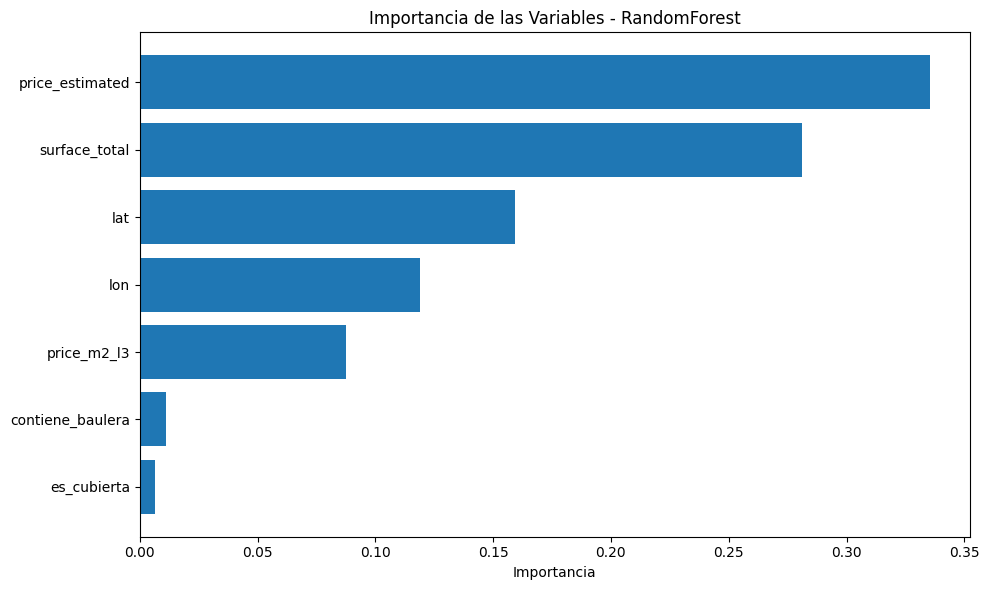

In [81]:
importances = reg.feature_importances_
feature_names = X_cocheras.columns


feat_importances = pd.DataFrame({
    "feature": feature_names,
    "importance": importances
}).sort_values("importance", ascending=False)

# Mostramos el ranking
print(feat_importances)

# Gráfico (opcional)
plt.figure(figsize=(10, 6))
plt.barh(feat_importances["feature"], feat_importances["importance"])
plt.gca().invert_yaxis()
plt.title("Importancia de las Variables - RandomForest")
plt.xlabel("Importancia")
plt.tight_layout()
plt.show()

# 🏙️ Departamentos

In [82]:
df_ent_departamentos = df_ent[df_ent["property_type"] == "Departamento"].copy()
df_ap_departamentos = df_ap[df_ap["property_type"] == "Departamento"].copy()

In [83]:
palabras_clave = ["mármol", "marmol", "mármoles", "marmoles"]
nombre_de_columna = "con_piso_de_marmol"

palabra_clave_a_columna(df_ent_departamentos, palabras_clave, nombre_de_columna)
palabra_clave_a_columna(df_ap_departamentos, palabras_clave, nombre_de_columna)

In [84]:
palabras_clave = ["roble"]
nombre_de_columna = "con_piso_de_roble"

palabra_clave_a_columna(df_ent_departamentos, palabras_clave, nombre_de_columna)
palabra_clave_a_columna(df_ap_departamentos, palabras_clave, nombre_de_columna)

In [85]:
palabras_clave = ["porcelanato"]
nombre_de_columna = "con_piso_de_porcelanato"

palabra_clave_a_columna(df_ent_departamentos, palabras_clave, nombre_de_columna)
palabra_clave_a_columna(df_ap_departamentos, palabras_clave, nombre_de_columna)

In [86]:
palabras_clave = ["vista al rio", "vista al río"]
nombre_de_columna = "con_vista_al_rio"

palabra_clave_a_columna(df_ent_departamentos, palabras_clave, nombre_de_columna)
palabra_clave_a_columna(df_ap_departamentos, palabras_clave, nombre_de_columna)

In [87]:
palabras_clave = ["sum", "zum", "salón de usos múltiples", "salon de usos múltiples", "salon de usos multiples", "salón de usos multiples"]
nombre_de_columna = "contiene_sum"

palabra_clave_a_columna(df_ent_departamentos, palabras_clave, nombre_de_columna)
palabra_clave_a_columna(df_ap_departamentos, palabras_clave, nombre_de_columna)

In [88]:
palabras_clave = ["estilo frances", "estilo francés"]
nombre_de_columna = "estilo_frances"

palabra_clave_a_columna(df_ent_departamentos, palabras_clave, nombre_de_columna)
palabra_clave_a_columna(df_ap_departamentos, palabras_clave, nombre_de_columna)

In [89]:
palabras_clave = ["penthouse"]
nombre_de_columna = "contiene_penthouse"

palabra_clave_a_columna(df_ent_departamentos, palabras_clave, nombre_de_columna)
palabra_clave_a_columna(df_ap_departamentos, palabras_clave, nombre_de_columna)

In [90]:
palabras_clave = ["lujoso", "élite","elite", "alta gama", "premium", "elegante", "glamoroso", "privilegiado", "de categoría", "alto nivel", "primera calidad"]
nombre_de_columna = "es_lujoso"

palabra_clave_a_columna(df_ent_departamentos, palabras_clave, nombre_de_columna)
palabra_clave_a_columna(df_ap_departamentos, palabras_clave, nombre_de_columna)

In [91]:
palabras_clave = ["piso alto"]
nombre_de_columna = "es_piso_alto"

palabra_clave_a_columna(df_ent_departamentos, palabras_clave, nombre_de_columna)
palabra_clave_a_columna(df_ap_departamentos, palabras_clave, nombre_de_columna)

In [92]:
palabras_clave = ["terraza", "solarium"]
nombre_de_columna = "contiene_terraza"

palabra_clave_a_columna(df_ent_departamentos, palabras_clave, nombre_de_columna)
palabra_clave_a_columna(df_ap_departamentos, palabras_clave, nombre_de_columna)

In [93]:
palabras_clave = ["patio"]
nombre_de_columna = "contiene_patio"

palabra_clave_a_columna(df_ent_departamentos, palabras_clave, nombre_de_columna)
palabra_clave_a_columna(df_ap_departamentos, palabras_clave, nombre_de_columna)

In [94]:
palabras_clave = ["cochera", "garaje", "garage", "estacionamiento"]
nombre_de_columna = "contiene_cochera"

palabra_clave_a_columna(df_ent_departamentos, palabras_clave, nombre_de_columna)
palabra_clave_a_columna(df_ap_departamentos, palabras_clave, nombre_de_columna)

In [95]:
palabras_clave = ["seguridad"]
nombre_de_columna = "contiene_seguridad"

palabra_clave_a_columna(df_ent_departamentos, palabras_clave, nombre_de_columna)
palabra_clave_a_columna(df_ap_departamentos, palabras_clave, nombre_de_columna)

In [96]:
palabras_clave = ["gimnasio", "gymnasio"]
nombre_de_columna = "contiene_gimnasio"

palabra_clave_a_columna(df_ent_departamentos, palabras_clave, nombre_de_columna)
palabra_clave_a_columna(df_ap_departamentos, palabras_clave, nombre_de_columna)

In [97]:
palabras_clave = [
    "jacuzzi", "jacuzi", "jacusi", "yacuzzi", "yacusi",
    "yacuxi", "jacuxi", "jacuzzy", "jacuzie", "jacuzzis",
    "yacuzi", "yacuzzy", "yacuzie", "jakuzzi", "yakuzzi"]
nombre_de_columna = "contiene_jacuzzi"

palabra_clave_a_columna(df_ent_departamentos, palabras_clave, nombre_de_columna)
palabra_clave_a_columna(df_ap_departamentos, palabras_clave, nombre_de_columna)

In [98]:
palabras_clave = ["reciclar", "refaccionar", "refacionar", "restaurar"]
nombre_de_columna = "a_refaccionar"

palabra_clave_a_columna(df_ent_departamentos, palabras_clave, nombre_de_columna)
palabra_clave_a_columna(df_ap_departamentos, palabras_clave, nombre_de_columna)

In [99]:
palabras_clave = ["micro cine", "microcine"]
nombre_de_columna = "contiene_microcine"

palabra_clave_a_columna(df_ent_departamentos, palabras_clave, nombre_de_columna)
palabra_clave_a_columna(df_ap_departamentos, palabras_clave, nombre_de_columna)

In [100]:
# Hay varios valores nan en las columnas bathrooms, rooms y bedrooms de df_ap y df_ent. Los voy a rellenar a partir de la descripción y el título con la función imputar_desde_texto.

patrones_banios = {
    1: ["1 baño", "un baño", "1baño", "unbaño"],
    2: ["2 baños", "dos baños", "2baños", "dosbaños"],
    3: ["3 baños", "tres baños", "3baños", "tresbaños"],
    4: ["4 baños", "cuatro baños", "4baños", "cuatrobaños"],
    5: ["5 baños", "cinco baños", "5baños", "cincobaños"],
    6: ["6 baños", "seis baños", "6baños", "seisbaños"],
    7: ["7 baños", "siete baños", "7baños", "sietebaños"],
    8: ["8 baños", "ocho baños", "8baños", "ochobaños"],
    9: ["9 baños", "nueve baños", "9baños", "nuevebaños"]
}

imputar_desde_texto(df_ent_departamentos, "bathrooms", patrones=patrones_banios)
imputar_desde_texto(df_ap_departamentos, "bathrooms", patrones=patrones_banios)

In [101]:
patrones_rooms = {
    1: ["1 ambiente", "un ambiente", "monoambiente"],
    2: ["2 ambientes", "dos ambientes"],
    3: ["3 ambientes", "tres ambientes"],
    4: ["4 ambientes", "cuatro ambientes"],
    5: ["5 ambientes", "cinco ambientes"],
    6: ["6 ambientes", "seis ambientes"],
    7: ["7 ambientes", "siete ambientes"],
    8: ["8 ambientes", "ocho ambientes"],
    9: ["9 ambientes", "nueve ambientes"],
    10: ["10 ambientes", "diez ambientes"]
}

imputar_desde_texto(df_ent_departamentos, "rooms", patrones=patrones_rooms)
imputar_desde_texto(df_ap_departamentos, "rooms", patrones=patrones_rooms)

In [102]:
patrones_bedrooms = {
    1: ["1 dormitorio", "un dormitorio", "monoambiente"],
    2: ["2 dormitorios", "dos dormitorios"],
    3: ["3 dormitorios", "tres dormitorios"],
    4: ["4 dormitorios", "cuatro dormitorios"],
    5: ["5 dormitorios", "cinco dormitorios"],
    6: ["6 dormitorios", "seis dormitorios"],
    7: ["7 dormitorios", "siete dormitorios"],
    8: ["8 dormitorios", "ocho dormitorios"],
    9: ["9 dormitorios", "nueve dormitorios"],
    10: ["10 dormitorios", "diez dormitorios"]
}

imputar_desde_texto(df_ent_departamentos, "bedrooms", patrones=patrones_bedrooms)
imputar_desde_texto(df_ap_departamentos, "bedrooms", patrones=patrones_bedrooms)

In [103]:
# Completo rooms con bedrooms + 1
df_ent_departamentos["rooms"] = df_ent_departamentos["rooms"].fillna(df_ent_departamentos["bedrooms"] + 1)

# Completo bedrooms con rooms - 1
df_ent_departamentos["bedrooms"] = df_ent_departamentos["bedrooms"].fillna(df_ent_departamentos["rooms"] - 1)

# Completo rooms con bedrooms + 1
df_ap_departamentos["rooms"] = df_ap_departamentos["rooms"].fillna(df_ap_departamentos["bedrooms"] + 1)

# Completo bedrooms con rooms - 1
df_ap_departamentos["bedrooms"] = df_ap_departamentos["bedrooms"].fillna(df_ap_departamentos["rooms"] - 1)

In [104]:
max_vals_ent = df_ent_departamentos[["surface_total", "surface_covered"]].max(axis=1)
min_vals_ent = df_ent_departamentos[["surface_total", "surface_covered"]].min(axis=1)

df_ent_departamentos["surface_total"] = max_vals_ent
df_ent_departamentos["surface_covered"] = min_vals_ent

max_vals_ap = df_ap_departamentos[["surface_total", "surface_covered"]].max(axis=1)
min_vals_ap = df_ap_departamentos[["surface_total", "surface_covered"]].min(axis=1)

df_ap_departamentos["surface_total"] = max_vals_ap
df_ap_departamentos["surface_covered"] = min_vals_ap

In [105]:
for df in [df_ent_departamentos, df_ap_departamentos]:
    completar_monoambientes(df)

In [106]:
# Corrección de registros que dicen "monoambiente" pero tienen 2 o más ambientes
for df in [df_ent_departamentos, df_ap_departamentos]:
    mask_monoambiente_excesivo = (
        df["title"].str.lower().str.contains("monoambiente", na=False)
        & (df["rooms"] >= 2)
    )

    df.loc[mask_monoambiente_excesivo, "rooms"] = 1
    df.loc[mask_monoambiente_excesivo, "bedrooms"] = 0
    df.loc[mask_monoambiente_excesivo, "bathrooms"] = 1

In [107]:
df_ent_departamentos = df_ent_departamentos.dropna(subset=["surface_total"])

In [108]:
df_ent_departamentos = imputar_por_superficie(df_ent_departamentos)
df_ap_departamentos = imputar_por_superficie(df_ap_departamentos)

In [109]:
# Calcular superficie mínima y máxima en df_ap_departamentos
valor_minimo_departamento = df_ap_departamentos["surface_total"].min()
valor_maximo_departamento = df_ap_departamentos["surface_total"].max()

# Crear máscara en df_ent_departamentos para mantener los que están dentro del rango válido
mask_surface_dep = (
    (df_ent_departamentos["surface_total"] >= valor_minimo_departamento) &
    (df_ent_departamentos["surface_total"] <= valor_maximo_departamento)
)

# Filtrar df_ent_departamentos para conservar solo los que tienen superficie cubierta válida
df_ent_departamentos = df_ent_departamentos[mask_surface_dep].copy()

In [110]:
# 1. Calcular precio por m² en df_ent_departamentos (dataset base)
df_ent_departamentos["price_m2"] = df_ent_departamentos["price"] / df_ent_departamentos["surface_total"]

In [111]:
# 1. Calcular precio por m² cubierto en df_ent_departamentos (dataset base)
df_ent_departamentos["price_m2_covered"] = df_ent_departamentos["price"] / df_ent_departamentos["surface_covered"]

In [112]:
# Me quedo con los registros que cumplen la siguiente condición:
df_ent_departamentos = df_ent_departamentos.loc[(df_ent_departamentos["price_m2"] > 500) & (df_ent_departamentos["price_m2"] < 10000)]

In [113]:
# Obtenemos los barrios únicos en df_ap_departamentos
barrios_ap = df_ap_departamentos["l3"].unique()

# Filtramos df_ent_departamentos quedándonos solo con los barrios en df_ap_departamentos
df_ent_departamentos = df_ent_departamentos[df_ent_departamentos["l3"].isin(barrios_ap)]

In [114]:
# 2. Mediana de precio por m² por barrio (l3) - Solo departamentos
price_m2_l3_departamentos = df_ent_departamentos.groupby("l3")["price_m2"].median()

# 3. Mapear a df_ent_departamentos (entrenamiento)
df_ent_departamentos["price_m2_l3"] = df_ent_departamentos["l3"].map(price_m2_l3_departamentos)

# 4. Mapear a df_ap_departamentos (predicción)
df_ap_departamentos["price_m2_l3"] = df_ap_departamentos["l3"].map(price_m2_l3_departamentos)

In [115]:
# 2. Mediana de precio por m² cubierto por barrio (l3) - Solo departamentos
price_m2_covered_l3_departamentos = df_ent_departamentos.groupby("l3")["price_m2_covered"].median()

# 3. Mapear a df_ent_departamentos (entrenamiento)
df_ent_departamentos["price_m2_covered_l3"] = df_ent_departamentos["l3"].map(price_m2_covered_l3_departamentos)

# 4. Mapear a df_ap_departamentos (predicción)
df_ap_departamentos["price_m2_covered_l3"] = df_ap_departamentos["l3"].map(price_m2_covered_l3_departamentos)

In [116]:
# Filtro registros donde el valor de precio por m2 tenga una diferencia mayor a 1000 con la mediana por l3 en departamentos
dif_price_m2_departamentos = (df_ent_departamentos['price_m2'] - df_ent_departamentos['price_m2_l3']) > 1000
df_ent_departamentos = df_ent_departamentos.loc[~dif_price_m2_departamentos]

In [117]:
df_ent_departamentos = df_ent_departamentos.loc[~(df_ent_departamentos.surface_covered < 14)]

In [118]:
# Eliminar price_m2 porque solo existe en df_ent_departamentos y ya se usó
df_ent_departamentos = df_ent_departamentos.drop(columns=["price_m2", "price_m2_covered"])

In [119]:
# Creo la variable del precio estimado a partir del precio por m2 por l3 y prop type y sup total
df_ent_departamentos['price_estimated_sup_total'] = df_ent_departamentos['surface_total'] * df_ent_departamentos['price_m2_l3']
df_ap_departamentos['price_estimated_sup_total'] = df_ap_departamentos['surface_total'] * df_ap_departamentos['price_m2_l3']

In [120]:
# Crear variable de precio estimado usando price_m2_covered_l3 y surface_covered
df_ent_departamentos['price_estimated_sup_cov'] = df_ent_departamentos['surface_covered'] * df_ent_departamentos['price_m2_covered_l3']
df_ap_departamentos['price_estimated_sup_cov'] = df_ap_departamentos['surface_covered'] * df_ap_departamentos['price_m2_covered_l3']

In [121]:
# df_ent_departamentos['ratio_price_est_total_cov'] = df_ent_departamentos['price_estimated_sup_total'] / df_ent_departamentos['price_estimated_sup_cov']
# df_ap_departamentos['ratio_price_est_total_cov'] = df_ap_departamentos['price_estimated_sup_total'] / df_ap_departamentos['price_estimated_sup_cov']

## Departamentos menos Puerto Madero

In [122]:
df_ent_departamentos_menos_pm = df_ent_departamentos[df_ent_departamentos["l3"] != "Puerto Madero"].copy()
df_ap_departamentos_menos_pm = df_ap_departamentos[df_ap_departamentos["l3"] != "Puerto Madero"].copy()

In [123]:
df_ent_departamentos_menos_pm = df_ent_departamentos_menos_pm.select_dtypes(include=['number', 'bool'])

In [124]:
X_departamentos = df_ent_departamentos_menos_pm[df_ent_departamentos_menos_pm.columns.drop('price')]
y_departamentos = df_ent_departamentos_menos_pm['price']

In [125]:
X_train_departamentos, X_test_departamentos, y_train_departamentos, y_test_departamentos = sk.model_selection.train_test_split(X_departamentos, y_departamentos, test_size=0.2, random_state=42)

n_estimators = 400
max_depth = 30
max_features = "sqrt"
min_samples_leaf = 1
min_samples_split = 2


reg = sk.ensemble.RandomForestRegressor(n_estimators=n_estimators, max_depth=max_depth, n_jobs=-1, random_state=42, min_samples_split=min_samples_split, min_samples_leaf=min_samples_leaf, max_features=max_features)

_ = reg.fit(X_train_departamentos, y_train_departamentos)


# Cálculo del error en entrenamiento (train)
y_pred_departamentos = reg.predict(X_train_departamentos)
score_train_departamentos = sk.metrics.root_mean_squared_error(y_train_departamentos, y_pred_departamentos)


# Cálculo del error en prueba (test)
y_pred_departamentos = reg.predict(X_test_departamentos)
score_test_departamentos  = sk.metrics.root_mean_squared_error(y_test_departamentos,  y_pred_departamentos)

print(f"{n_estimators=} -- {max_depth=} --> {score_train_departamentos=:.2f} - {score_test_departamentos=:.2f}")

n_estimators=400 -- max_depth=30 --> score_train_departamentos=13682.00 - score_test_departamentos=36374.16


In [126]:
X_departamentos = df_ent_departamentos_menos_pm[df_ent_departamentos_menos_pm.columns.drop('price')]
y_departamentos = df_ent_departamentos_menos_pm['price']

# Entrenamos el modelo con todos los datos de entrenamiento
reg.fit(X_departamentos, y_departamentos)

RandomForestRegressor(max_depth=30, max_features='sqrt', n_estimators=400,
                      n_jobs=-1, random_state=42)

In [127]:
df_ap_departamentos_menos_pm = df_ap_departamentos_menos_pm.select_dtypes(include=['number', 'bool'])

X_ap_departamentos = df_ap_departamentos_menos_pm[X_departamentos.columns]

y_pred_ap_departamentos_menos_pm = pd.Series(reg.predict(X_ap_departamentos), index=df_ap_departamentos_menos_pm.index)

                      feature  importance
26  price_estimated_sup_total    0.244315
27    price_estimated_sup_cov    0.220564
6             surface_covered    0.147748
5               surface_total    0.138829
4                   bathrooms    0.047117
2                       rooms    0.046745
3                    bedrooms    0.027250
25        price_m2_covered_l3    0.027236
1                         lat    0.026224
24                price_m2_l3    0.024769
0                         lon    0.013684
18           contiene_cochera    0.011574
19         contiene_seguridad    0.003775
11               contiene_sum    0.003560
16           contiene_terraza    0.002383
17             contiene_patio    0.002246
14                  es_lujoso    0.002158
8           con_piso_de_roble    0.001654
20          contiene_gimnasio    0.001341
13         contiene_penthouse    0.001136
21           contiene_jacuzzi    0.001084
22              a_refaccionar    0.000986
9     con_piso_de_porcelanato    0

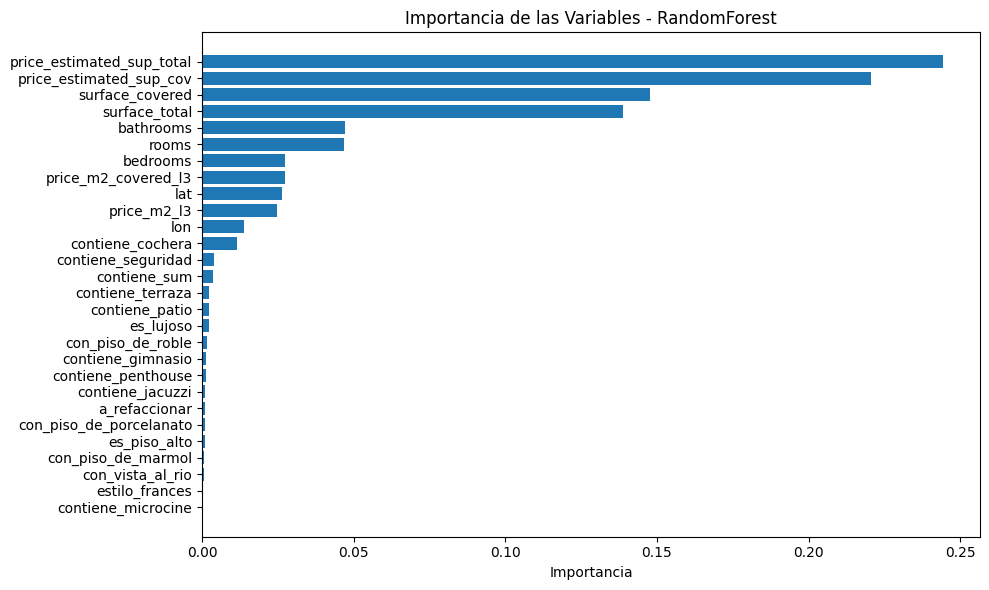

In [128]:
importances = reg.feature_importances_
feature_names = X_departamentos.columns


feat_importances = pd.DataFrame({
    "feature": feature_names,
    "importance": importances
}).sort_values("importance", ascending=False)

# Mostramos el ranking
print(feat_importances)

# Gráfico (opcional)
plt.figure(figsize=(10, 6))
plt.barh(feat_importances["feature"], feat_importances["importance"])
plt.gca().invert_yaxis()
plt.title("Importancia de las Variables - RandomForest")
plt.xlabel("Importancia")
plt.tight_layout()
plt.show()

## Departamentos en Puerto Madero

In [129]:
df_ent_departamentos_pm = df_ent_departamentos[df_ent_departamentos["l3"] == "Puerto Madero"].copy()
df_ap_departamentos_pm = df_ap_departamentos[df_ap_departamentos["l3"] == "Puerto Madero"].copy()

### 1. Alvear *Tower*

In [130]:
palabras_clave = ["alvear tower"]
nombre_de_columna = "alvear_tower"

palabra_clave_a_columna(df_ent_departamentos_pm, palabras_clave, nombre_de_columna)
palabra_clave_a_columna(df_ap_departamentos_pm, palabras_clave, nombre_de_columna)

### 2. Le Parc

In [131]:
palabras_clave = ["le parc"]
nombre_de_columna = "le_parc"

palabra_clave_a_columna(df_ent_departamentos_pm, palabras_clave, nombre_de_columna)
palabra_clave_a_columna(df_ap_departamentos_pm, palabras_clave, nombre_de_columna)

### 3. Torres Renoir

In [132]:
palabras_clave = ["renoir"]
nombre_de_columna = "renoir"

palabra_clave_a_columna(df_ent_departamentos_pm, palabras_clave, nombre_de_columna)
palabra_clave_a_columna(df_ap_departamentos_pm, palabras_clave, nombre_de_columna)

### 4. Torres El Faro

In [133]:
palabras_clave = ["el faro"]
nombre_de_columna = "el_faro"

palabra_clave_a_columna(df_ent_departamentos_pm, palabras_clave, nombre_de_columna)
palabra_clave_a_columna(df_ap_departamentos_pm, palabras_clave, nombre_de_columna)

In [134]:
elimino_columnas(df_ent_departamentos_pm, ["price_m2_l3", "price_m2_covered_l3", "a_refaccionar"])
elimino_columnas(df_ap_departamentos_pm, ["price_m2_l3", "price_m2_covered_l3", "a_refaccionar"])

In [135]:
df_ent_departamentos_pm = df_ent_departamentos_pm.select_dtypes(include=['number', 'bool'])

In [136]:
X_departamentos = df_ent_departamentos_pm[df_ent_departamentos_pm.columns.drop('price')]
y_departamentos = df_ent_departamentos_pm['price']

In [137]:
X_train_departamentos, X_test_departamentos, y_train_departamentos, y_test_departamentos = sk.model_selection.train_test_split(X_departamentos, y_departamentos, test_size=0.2, random_state=42)

n_estimators = 400
max_depth = 30
max_features = "sqrt"
min_samples_leaf = 1
min_samples_split = 2


reg = sk.ensemble.RandomForestRegressor(n_estimators=n_estimators, max_depth=max_depth, n_jobs=-1, random_state=42, min_samples_split=min_samples_split, min_samples_leaf=min_samples_leaf, max_features=max_features)

_ = reg.fit(X_train_departamentos, y_train_departamentos)


# Cálculo del error en entrenamiento (train)
y_pred_departamentos = reg.predict(X_train_departamentos)
score_train_departamentos = sk.metrics.root_mean_squared_error(y_train_departamentos, y_pred_departamentos)


# Cálculo del error en prueba (test)
y_pred_departamentos = reg.predict(X_test_departamentos)
score_test_departamentos  = sk.metrics.root_mean_squared_error(y_test_departamentos,  y_pred_departamentos)

print(f"{n_estimators=} -- {max_depth=} --> {score_train_departamentos=:.2f} - {score_test_departamentos=:.2f}")

n_estimators=400 -- max_depth=30 --> score_train_departamentos=37153.99 - score_test_departamentos=110178.21


In [138]:
X_departamentos = df_ent_departamentos_pm[df_ent_departamentos_pm.columns.drop('price')]
y_departamentos = df_ent_departamentos_pm['price']

# Entrenamos el modelo con todos los datos de entrenamiento
reg.fit(X_departamentos, y_departamentos)

RandomForestRegressor(max_depth=30, max_features='sqrt', n_estimators=400,
                      n_jobs=-1, random_state=42)

In [139]:
df_ap_departamentos_pm = df_ap_departamentos_pm.select_dtypes(include=['number', 'bool'])

X_ap_departamentos = df_ap_departamentos_pm[X_departamentos.columns]

y_pred_ap_departamentos_pm = pd.Series(reg.predict(X_ap_departamentos), index=df_ap_departamentos_pm.index)

                      feature  importance
24    price_estimated_sup_cov    0.205454
6             surface_covered    0.196695
23  price_estimated_sup_total    0.168870
5               surface_total    0.164398
8           con_piso_de_roble    0.060365
4                   bathrooms    0.050861
3                    bedrooms    0.038344
2                       rooms    0.033923
1                         lat    0.021605
0                         lon    0.014650
22         contiene_microcine    0.010263
27                     renoir    0.008916
18           contiene_cochera    0.004011
16           contiene_terraza    0.003023
20          contiene_gimnasio    0.002824
9     con_piso_de_porcelanato    0.002315
28                    el_faro    0.002049
7          con_piso_de_marmol    0.001998
21           contiene_jacuzzi    0.001930
10           con_vista_al_rio    0.001714
11               contiene_sum    0.001249
19         contiene_seguridad    0.001146
15               es_piso_alto    0

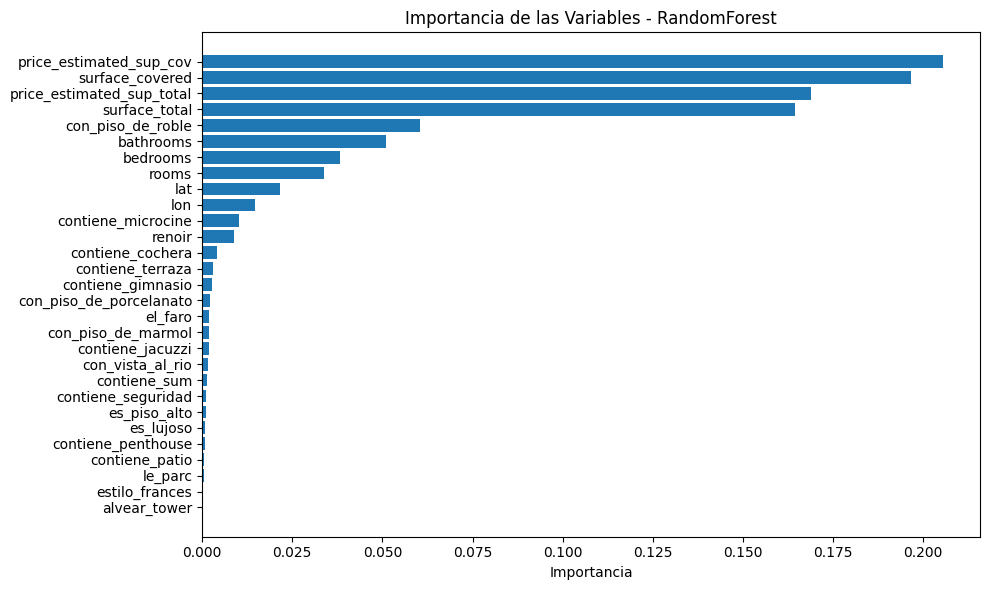

In [140]:
importances = reg.feature_importances_
feature_names = X_departamentos.columns


feat_importances = pd.DataFrame({
    "feature": feature_names,
    "importance": importances
}).sort_values("importance", ascending=False)

# Mostramos el ranking
print(feat_importances)

# Gráfico (opcional)
plt.figure(figsize=(10, 6))
plt.barh(feat_importances["feature"], feat_importances["importance"])
plt.gca().invert_yaxis()
plt.title("Importancia de las Variables - RandomForest")
plt.xlabel("Importancia")
plt.tight_layout()
plt.show()

# 🏠 Casas

In [141]:
df_ent_casas = df_ent[df_ent["property_type"] == "Casa"].copy()
df_ap_casas = df_ap[df_ap["property_type"] == "Casa"].copy()

In [142]:
palabras_clave = ["mármol", "marmol", "mármoles", "marmoles"]
nombre_de_columna = "con_piso_de_marmol"

palabra_clave_a_columna(df_ent_casas, palabras_clave, nombre_de_columna)
palabra_clave_a_columna(df_ap_casas, palabras_clave, nombre_de_columna)

In [143]:
palabras_clave = ["roble"]
nombre_de_columna = "con_piso_de_roble"

palabra_clave_a_columna(df_ent_casas, palabras_clave, nombre_de_columna)
palabra_clave_a_columna(df_ap_casas, palabras_clave, nombre_de_columna)

In [144]:
palabras_clave = ["porcelanato"]
nombre_de_columna = "con_piso_de_porcelanato"

palabra_clave_a_columna(df_ent_casas, palabras_clave, nombre_de_columna)
palabra_clave_a_columna(df_ap_casas, palabras_clave, nombre_de_columna)

In [145]:
palabras_clave = ["cochera", "garaje", "garage", "estacionamiento"]
nombre_de_columna = "contiene_cochera"

palabra_clave_a_columna(df_ent_casas, palabras_clave, nombre_de_columna)
palabra_clave_a_columna(df_ap_casas, palabras_clave, nombre_de_columna)

In [146]:
palabras_clave = ["sum", "zum", "salón de usos múltiples", "salon de usos múltiples", "salon de usos multiples", "salón de usos multiples"]
nombre_de_columna = "contiene_sum"

palabra_clave_a_columna(df_ent_casas, palabras_clave, nombre_de_columna)
palabra_clave_a_columna(df_ap_casas, palabras_clave, nombre_de_columna)

In [147]:
palabras_clave = ["mansión", "mansion"]
nombre_de_columna = "es_mansion"

palabra_clave_a_columna(df_ent_casas, palabras_clave, nombre_de_columna)
palabra_clave_a_columna(df_ap_casas, palabras_clave, nombre_de_columna)

In [148]:
palabras_clave = ["estilo frances", "estilo francés"]
nombre_de_columna = "estilo_frances"

palabra_clave_a_columna(df_ent_casas, palabras_clave, nombre_de_columna)
palabra_clave_a_columna(df_ap_casas, palabras_clave, nombre_de_columna)

In [149]:
palabras_clave = ["quincho"]
nombre_de_columna = "contiene_quincho"

palabra_clave_a_columna(df_ent_casas, palabras_clave, nombre_de_columna)
palabra_clave_a_columna(df_ap_casas, palabras_clave, nombre_de_columna)

In [150]:
palabras_clave = ["terraza", "solarium"]
nombre_de_columna = "contiene_terraza"

palabra_clave_a_columna(df_ent_casas, palabras_clave, nombre_de_columna)
palabra_clave_a_columna(df_ap_casas, palabras_clave, nombre_de_columna)

In [151]:
palabras_clave = ["embajada", "embajadas"]
nombre_de_columna = "zona_de_embajadas"

palabra_clave_a_columna(df_ent_casas, palabras_clave, nombre_de_columna)
palabra_clave_a_columna(df_ap_casas, palabras_clave, nombre_de_columna)

In [152]:
palabras_clave = ["jardín", "jardin"]
nombre_de_columna = "contiene_jardin"

palabra_clave_a_columna(df_ent_casas, palabras_clave, nombre_de_columna)
palabra_clave_a_columna(df_ap_casas, palabras_clave, nombre_de_columna)

In [153]:
palabras_clave = ['piscina', 'picina', 'pisina', 'pileta']
nombre_de_columna = "contiene_pileta"

palabra_clave_a_columna(df_ent_casas, palabras_clave, nombre_de_columna)
palabra_clave_a_columna(df_ap_casas, palabras_clave, nombre_de_columna)

In [154]:
palabras_clave = ["reciclar", "refaccionar", "refacionar", "restaurar"]
nombre_de_columna = "a_refaccionar"

palabra_clave_a_columna(df_ent_casas, palabras_clave, nombre_de_columna)
palabra_clave_a_columna(df_ap_casas, palabras_clave, nombre_de_columna)

In [155]:
palabras_clave = ["micro cine", "microcine"]
nombre_de_columna = "contiene_microcine"

palabra_clave_a_columna(df_ent_casas, palabras_clave, nombre_de_columna)
palabra_clave_a_columna(df_ap_casas, palabras_clave, nombre_de_columna)

In [156]:
# Hay varios valores nan en las columnas bathrooms, rooms y bedrooms de df_ap y df_ent. Los voy a rellenar a partir de la descripción y el título con la función imputar_desde_texto.

patrones_banios = {
    1: ["1 baño", "un baño", "1baño", "unbaño"],
    2: ["2 baños", "dos baños", "2baños", "dosbaños"],
    3: ["3 baños", "tres baños", "3baños", "tresbaños"],
    4: ["4 baños", "cuatro baños", "4baños", "cuatrobaños"],
    5: ["5 baños", "cinco baños", "5baños", "cincobaños"],
    6: ["6 baños", "seis baños", "6baños", "seisbaños"],
    7: ["7 baños", "siete baños", "7baños", "sietebaños"],
    8: ["8 baños", "ocho baños", "8baños", "ochobaños"],
    9: ["9 baños", "nueve baños", "9baños", "nuevebaños"]
}

imputar_desde_texto(df_ent_casas, "bathrooms", patrones=patrones_banios)
imputar_desde_texto(df_ap_casas, "bathrooms", patrones=patrones_banios)

In [157]:
patrones_rooms = {
    1: ["1 ambiente", "un ambiente", "monoambiente"],
    2: ["2 ambientes", "dos ambientes"],
    3: ["3 ambientes", "tres ambientes"],
    4: ["4 ambientes", "cuatro ambientes"],
    5: ["5 ambientes", "cinco ambientes"],
    6: ["6 ambientes", "seis ambientes"],
    7: ["7 ambientes", "siete ambientes"],
    8: ["8 ambientes", "ocho ambientes"],
    9: ["9 ambientes", "nueve ambientes"],
    10: ["10 ambientes", "diez ambientes"]
}

imputar_desde_texto(df_ent_casas, "rooms", patrones=patrones_rooms)
imputar_desde_texto(df_ap_casas, "rooms", patrones=patrones_rooms)

In [158]:
patrones_bedrooms = {
    1: ["1 dormitorio", "un dormitorio", "monoambiente"],
    2: ["2 dormitorios", "dos dormitorios"],
    3: ["3 dormitorios", "tres dormitorios"],
    4: ["4 dormitorios", "cuatro dormitorios"],
    5: ["5 dormitorios", "cinco dormitorios"],
    6: ["6 dormitorios", "seis dormitorios"],
    7: ["7 dormitorios", "siete dormitorios"],
    8: ["8 dormitorios", "ocho dormitorios"],
    9: ["9 dormitorios", "nueve dormitorios"],
    10: ["10 dormitorios", "diez dormitorios"]
}

imputar_desde_texto(df_ent_casas, "bedrooms", patrones=patrones_bedrooms)
imputar_desde_texto(df_ap_casas, "bedrooms", patrones=patrones_bedrooms)

In [159]:
# Completo rooms con bedrooms + 1
df_ent_casas["rooms"] = df_ent_casas["rooms"].fillna(df_ent_casas["bedrooms"] + 1)

# Completo bedrooms con rooms - 1
df_ent_casas["bedrooms"] = df_ent_casas["bedrooms"].fillna(df_ent_casas["rooms"] - 1)

# Completo rooms con bedrooms + 1
df_ap_casas["rooms"] = df_ap_casas["rooms"].fillna(df_ap_casas["bedrooms"] + 1)

# Completo bedrooms con rooms - 1
df_ap_casas["bedrooms"] = df_ap_casas["bedrooms"].fillna(df_ap_casas["rooms"] - 1)

In [160]:
max_vals_ent = df_ent_casas[["surface_total", "surface_covered"]].max(axis=1)
min_vals_ent = df_ent_casas[["surface_total", "surface_covered"]].min(axis=1)

df_ent_casas["surface_total"] = max_vals_ent
df_ent_casas["surface_covered"] = min_vals_ent

max_vals_ap = df_ap_casas[["surface_total", "surface_covered"]].max(axis=1)
min_vals_ap = df_ap_casas[["surface_total", "surface_covered"]].min(axis=1)

df_ap_casas["surface_total"] = max_vals_ap
df_ap_casas["surface_covered"] = min_vals_ap

In [161]:
for df in [df_ent_casas, df_ap_casas]:
    completar_monoambientes(df)

In [162]:
# Corrección de registros que dicen "monoambiente" pero tienen 2 o más ambientes
for df in [df_ent_casas, df_ap_casas]:
    mask_monoambiente_excesivo = (
        df["title"].str.lower().str.contains("monoambiente", na=False)
        & (df["rooms"] >= 2)
    )

    df.loc[mask_monoambiente_excesivo, "rooms"] = 1
    df.loc[mask_monoambiente_excesivo, "bedrooms"] = 0
    df.loc[mask_monoambiente_excesivo, "bathrooms"] = 1

In [163]:
df_ent_casas = df_ent_casas.dropna(subset=["surface_total"])

In [164]:
df_ent_casas = imputar_por_superficie(df_ent_casas)
df_ap_casas = imputar_por_superficie(df_ap_casas)

In [165]:
# Calcular superficie mínima y máxima en df_ap_casas
valor_minimo_casa = df_ap_casas["surface_total"].min()
valor_maximo_casa = df_ap_casas["surface_total"].max()

# Crear máscara en df_ent_casas para mantener los que están dentro del rango válido
mask_surface_dep = (
    (df_ent_casas["surface_total"] >= valor_minimo_casa) &
    (df_ent_casas["surface_total"] <= valor_maximo_casa)
)

# Filtrar df_ent_casas para conservar solo los que tienen superficie cubierta válida
df_ent_casas = df_ent_casas[mask_surface_dep].copy()

In [166]:
# 1. Calcular precio por m² en df_ent_casas (dataset base)
df_ent_casas["price_m2"] = df_ent_casas["price"] / df_ent_casas["surface_total"]

In [167]:
# 1. Calcular precio por m² cubierto en df_ent_casas (dataset base)
df_ent_casas["price_m2_covered"] = df_ent_casas["price"] / df_ent_casas["surface_covered"]

In [168]:
# Me quedo con los registros que cumplen la siguiente condición:
df_ent_casas = df_ent_casas.loc[(df_ent_casas["price_m2"] > 500) & (df_ent_casas["price_m2"] < 10000)].copy()

In [169]:
# Obtenemos los barrios únicos en df_ap_casas
barrios_ap = df_ap_casas["l3"].unique()

# Filtramos df_ent_casas quedándonos solo con los barrios en df_ap_casas
df_ent_casas = df_ent_casas[df_ent_casas["l3"].isin(barrios_ap)].copy()

In [170]:
# 2. Mediana de precio por m² por barrio (l3) - Solo casas
price_m2_l3_casas = df_ent_casas.groupby("l3")["price_m2"].median()

# 3. Mapear a df_ent_casas (entrenamiento)
df_ent_casas["price_m2_l3"] = df_ent_casas["l3"].map(price_m2_l3_casas)

# 4. Mapear a df_ap_casas (predicción)
df_ap_casas["price_m2_l3"] = df_ap_casas["l3"].map(price_m2_l3_casas)

In [171]:
# 2. Mediana de precio por m² cubierto por barrio (l3) - Solo casas
price_m2_covered_l3_casas = df_ent_casas.groupby("l3")["price_m2_covered"].median()

# 3. Mapear a df_ent_casas (entrenamiento)
df_ent_casas["price_m2_covered_l3"] = df_ent_casas["l3"].map(price_m2_covered_l3_casas)

# 4. Mapear a df_ap_casas (predicción)
df_ap_casas["price_m2_covered_l3"] = df_ap_casas["l3"].map(price_m2_covered_l3_casas)

In [172]:
# Filtro registros donde el valor de precio por m2 tenga una diferencia mayor a 1000 con la mediana por l3 en casas
dif_price_m2_casas = (df_ent_casas['price_m2'] - df_ent_casas['price_m2_l3']) > 1000
df_ent_casas = df_ent_casas.loc[~dif_price_m2_casas]

In [173]:
df_ent_casas = df_ent_casas.loc[~(df_ent_casas["surface_covered"] < 25)]

In [174]:
# Eliminar price_m2 porque solo existe en df_ent_casas y ya se usó
df_ent_casas = df_ent_casas.drop(columns=["price_m2", "price_m2_covered"])

In [175]:
# Creo la variable del precio estimado a partir del precio por m2 por l3 y prop type y sup total
df_ent_casas['price_estimated_sup_total'] = df_ent_casas['surface_total'] * df_ent_casas['price_m2_l3']
df_ap_casas['price_estimated_sup_total'] = df_ap_casas['surface_total'] * df_ap_casas['price_m2_l3']

In [176]:
# Crear variable de precio estimado usando price_m2_covered_l3 y surface_covered
df_ent_casas['price_estimated_sup_cov'] = df_ent_casas['surface_covered'] * df_ent_casas['price_m2_covered_l3']
df_ap_casas['price_estimated_sup_cov'] = df_ap_casas['surface_covered'] * df_ap_casas['price_m2_covered_l3']

In [177]:
# df_ent_casas['ratio_price_est_total_cov'] = df_ent_casas['price_estimated_sup_total'] / df_ent_casas['price_estimated_sup_cov']
# df_ap_casas['ratio_price_est_total_cov'] = df_ap_casas['price_estimated_sup_total'] / df_ap_casas['price_estimated_sup_cov']

In [178]:
df_ent_casas = df_ent_casas.select_dtypes(include=['number', 'bool'])

In [179]:
X_casas = df_ent_casas[df_ent_casas.columns.drop('price')]
y_casas = df_ent_casas['price']

In [180]:
X_train_casas, X_test_casas, y_train_casas, y_test_casas = sk.model_selection.train_test_split(X_casas, y_casas, test_size=0.2, random_state=42)

n_estimators = 400
max_depth = 30
max_features = "sqrt"
min_samples_leaf = 1
min_samples_split = 2


reg = sk.ensemble.RandomForestRegressor(n_estimators=n_estimators, max_depth=max_depth, n_jobs=-1, random_state=42, min_samples_split=min_samples_split, min_samples_leaf=min_samples_leaf, max_features=max_features)

_ = reg.fit(X_train_casas, y_train_casas)


# Cálculo del error en entrenamiento (train)
y_pred_casas = reg.predict(X_train_casas)
score_train_casas = sk.metrics.root_mean_squared_error(y_train_casas, y_pred_casas)


# Cálculo del error en prueba (test)
y_pred_casas = reg.predict(X_test_casas)
score_test_casas  = sk.metrics.root_mean_squared_error(y_test_casas,  y_pred_casas)

print(f"{n_estimators=} -- {max_depth=} --> {score_train_casas=:.2f} - {score_test_casas=:.2f}")

n_estimators=400 -- max_depth=30 --> score_train_casas=24307.71 - score_test_casas=55421.50


In [181]:
X_casas = df_ent_casas[df_ent_casas.columns.drop('price')]
y_casas = df_ent_casas['price']

# Entrenamos el modelo con todos los datos de entrenamiento
reg.fit(X_casas, y_casas)

RandomForestRegressor(max_depth=30, max_features='sqrt', n_estimators=400,
                      n_jobs=-1, random_state=42)

In [182]:
df_ap_casas = df_ap_casas.select_dtypes(include=['number', 'bool'])

X_ap_casas = df_ap_casas[X_casas.columns]

y_pred_ap_casas = pd.Series(reg.predict(X_ap_casas), index=df_ap_casas.index)

                      feature  importance
24    price_estimated_sup_cov    0.250156
23  price_estimated_sup_total    0.203362
6             surface_covered    0.160460
5               surface_total    0.099177
4                   bathrooms    0.063519
1                         lat    0.032566
3                    bedrooms    0.030510
21                price_m2_l3    0.028922
2                       rooms    0.028883
22        price_m2_covered_l3    0.027851
0                         lon    0.019508
17            contiene_jardin    0.013976
10           contiene_cochera    0.009747
18            contiene_pileta    0.007607
16          zona_de_embajadas    0.004519
15           contiene_terraza    0.003027
19              a_refaccionar    0.002808
14           contiene_quincho    0.002808
12                 es_mansion    0.002588
8           con_piso_de_roble    0.002382
7          con_piso_de_marmol    0.001495
13             estilo_frances    0.001400
11               contiene_sum    0

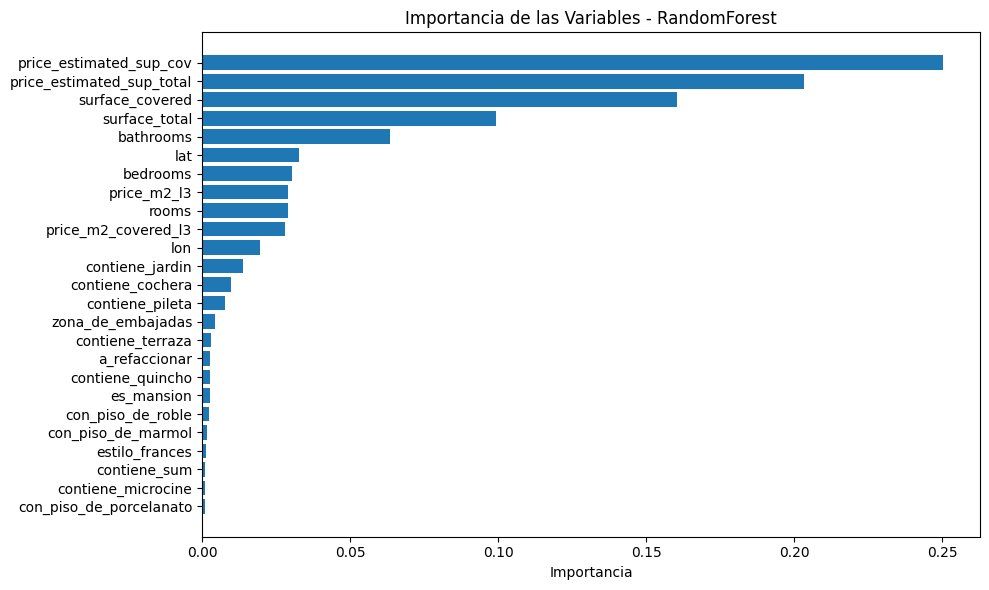

In [183]:
importances = reg.feature_importances_
feature_names = X_casas.columns


feat_importances = pd.DataFrame({
    "feature": feature_names,
    "importance": importances
}).sort_values("importance", ascending=False)

# Mostramos el ranking
print(feat_importances)

# Gráfico (opcional)
plt.figure(figsize=(10, 6))
plt.barh(feat_importances["feature"], feat_importances["importance"])
plt.gca().invert_yaxis()
plt.title("Importancia de las Variables - RandomForest")
plt.xlabel("Importancia")
plt.tight_layout()
plt.show()

# Predicciones de todas las propiedades

In [184]:
y_pred_ap = pd.concat([y_pred_ap_cocheras, y_pred_ap_departamentos_menos_pm, y_pred_ap_departamentos_pm, y_pred_ap_casas])

In [185]:
df_ap.loc[y_pred_ap.index, 'price'] = y_pred_ap

In [186]:
df_ap["price"].to_csv("solucion_Facundo_San_Martino_23_06_2025_1.csv")

In [187]:
df_ap["price"]

,price
id,
1068,473633.691862
1069,790056.167553
1073,206853.654167
1082,417404.080835
1091,256705.177381
...,...
960218,260983.240491
960220,322937.500000
960226,825000.000000


# Conclusiones

## Evaluación del modelo y del error



*   El modelo Random Forest Regressor logró capturar relaciones complejas y no lineales entre las características de las propiedades y sus precios en CABA.
*   El modelo obtuvo un RMSE de aproximadamente 29.419 en la competencia de Kaggle, lo que representa una buena capacidad predictiva dada la variabilidad del mercado.
*   Las propiedades con características atípicas concentraron los mayores errores de predicción.




## Importancia del preprocesamiento



*   El proceso de limpieza, transformación e imputación de datos fue clave para alcanzar un buen rendimiento.
*   Mejoras en la calidad y homogeneidad del dataset (por ejemplo, mejor codificación de las variables categóricas o manejo de outliers) pueden tener un impacto directo sobre el desempeño del modelo.



## Aplicación del aprendizaje automático al mercado inmobiliario

*   El modelo demuestra el potencial del aprendizaje automático para respaldar decisiones basadas en datos en el mercado inmobiliario.
*   Las predicciones pueden aportar valor tanto a compradores, vendedores como a agentes, brindando estimaciones objetivas del precio de las propiedades.
*   Este tipo de herramienta podría utilizarse para detectar propiedades sobrevaloradas o subvaloradas, mejorando la transparencia del mercado.